In [99]:
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit, cross_val_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from hyperopt import tpe, Trials, hp, fmin, STATUS_OK
from functools import partial
from sklearn.neighbors import KNeighborsClassifier

In [7]:
with open('X_padel_dropped.pickle', 'rb') as input:
    X_padel_dropped = pickle.load(input)

In [9]:
with open('X_standard_dropped.pickle', 'rb') as input:
    X_standard_dropped = pickle.load(input)

In [11]:
with open('y.pickle', 'rb') as input:
    target = pickle.load(input)


In [13]:
with open('X_standard_pca.pickle', 'rb') as input:
    X_standard_pca = pickle.load(input)

In [15]:
with open('X_padel_pca.pickle', 'rb') as input:
    X_padel_pca = pickle.load(input)

In [17]:
with open('groups.pickle', 'rb') as input:
    groups = pickle.load(input)

In [19]:
descriptors_dict = {'Standard':X_standard_dropped, 'Padel':X_padel_dropped}
descriptors_dict_pca = {'Standard':X_standard_pca, 'Padel':X_padel_pca}

In [21]:
scores = {'Descriptors':[], 'Full or PCA':[], 'Accuracy':[], 'F1 - score':[], 'ROC-AUC Score':[], 'Estimator':[]}

In [25]:
def get_best_model_from_trials(trials):
    valid_trial_list = [trial for trial in trials if trial['result']['status'] == STATUS_OK]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['Trained_model']

In [42]:
def calculate_to_score(estimator, estimator_name, param_grid, descriptors_dict = descriptors_dict, target=target, type = 'Full', groups = groups):
    fig, axes = plt.subplots(1, 2, figsize = (12,8))
    i = 0
    for key, value in descriptors_dict.items():
        #make pipe 
        pipe = make_pipeline(MinMaxScaler(), estimator)
        #split based on grou[s
        splitter = GroupShuffleSplit(n_splits=2, random_state = 0)
        split = splitter.split(X = value, y = target, groups = groups)
        train_indices, test_indices = next(split)
        X_train, y_train, groups_train = value.iloc[train_indices], target.iloc[train_indices], groups[train_indices]
        X_test, y_test, groups_test = value.iloc[test_indices], target.iloc[test_indices], groups[test_indices]
        #New K-fold stratification
        cv = StratifiedGroupKFold()
        #objective function
        def objective(params, pipeline, X, target, groups_train):
            score = cross_val_score(pipe, X_train, y_train, cv = cv, groups = groups_train)
            return {'loss':-score.mean(), 'status':STATUS_OK, 'Trained_model':pipeline}
        #find best exstimator
        trials = Trials()
        best = fmin(partial(objective, pipeline = pipe, X = X_train, target = y_train, groups_train = groups_train), 
                    space = param_grid, trials = trials, algo = tpe.suggest, max_evals=  50)
        best_estimator  = get_best_model_from_trials(trials)
        #fit, predict and find metric
        best_estimator.fit(X_train, y_train)
        predictions = best_estimator.predict(X_test)
        probs = best_estimator.predict_proba(X_test)[:,1]
        scores['Descriptors'].append(key)
        scores['Accuracy'].append(accuracy_score(y_test, predictions))
        scores['F1 - score'].append(f1_score(y_test, predictions))
        scores['ROC-AUC Score'].append(roc_auc_score(y_test, probs))
        scores['Full or PCA'].append(type)
        scores['Estimator'].append(estimator_name)
        fpr, tpr, _ = roc_curve(y_test, probs)
        axes[i].plot(fpr, tpr)
        axes[i].plot([0,1],[0,1], 'k--')
        axes[i].set_title('ROC-AUC Curve for {} descriptors'.format(key))
        axes[i].set_xlabel('False positive rate')
        axes[i].set_ylabel('True positive rate')
        i += 1
    plt.tight_layout()

**Logistic regression**

100%|██████████| 50/50 [00:38<00:00,  1.29trial/s, best loss: -0.6567292023319979]


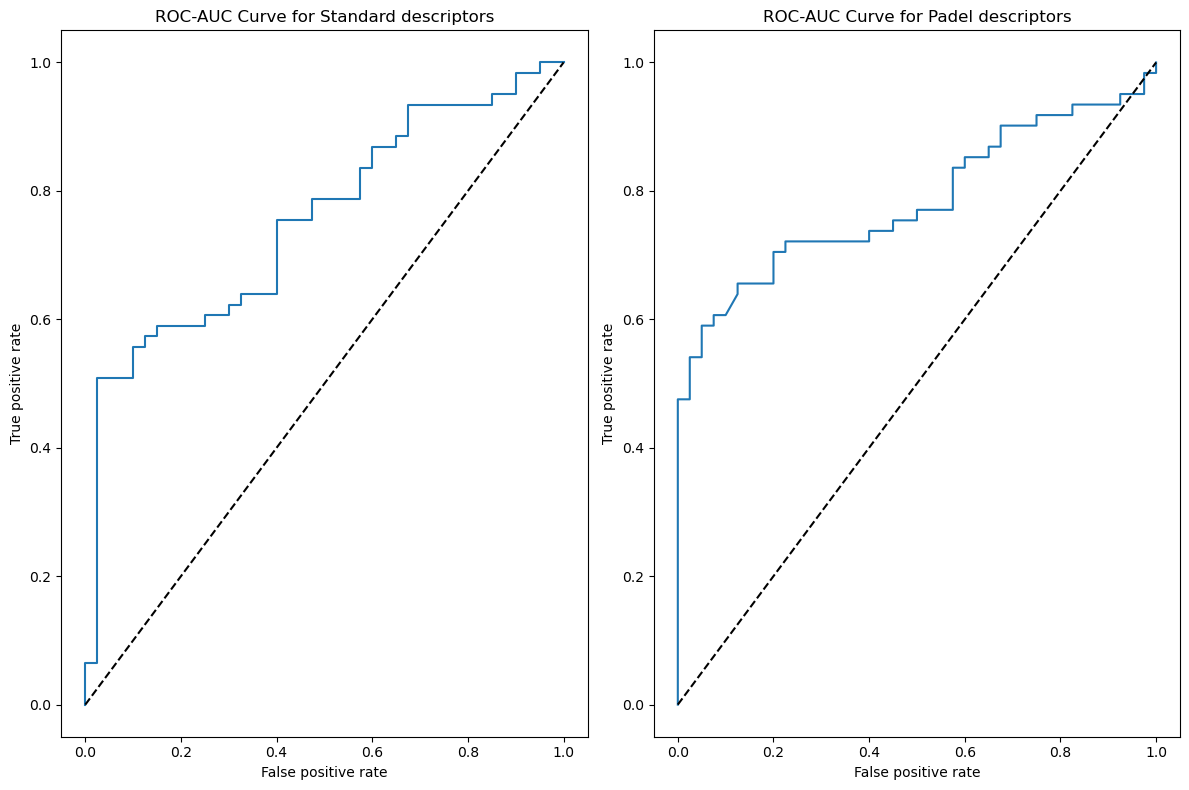

In [44]:
calculate_to_score(LogisticRegression(random_state = 0, max_iter = 1000), estimator_name='Logistic Regression', 
                   param_grid = {'logisticregression__C':hp.loguniform(label = 'C', low = -4*np.log(10), high  = 2*np.log(10)), 'logisticregression__penalty':hp.choice('penalty', ['l2', 'l1'])},
                  groups=groups)

In [46]:
pd.DataFrame(scores)

,Descriptors,Full or PCA,Accuracy,F1 - score,ROC-AUC Score,Estimator
0,Standard,Full,0.643564,0.684211,0.752869,Logistic Regression
1,Padel,Full,0.732673,0.765217,0.783607,Logistic Regression


100%|██████████| 50/50 [00:16<00:00,  3.05trial/s, best loss: -0.5061035515316238]


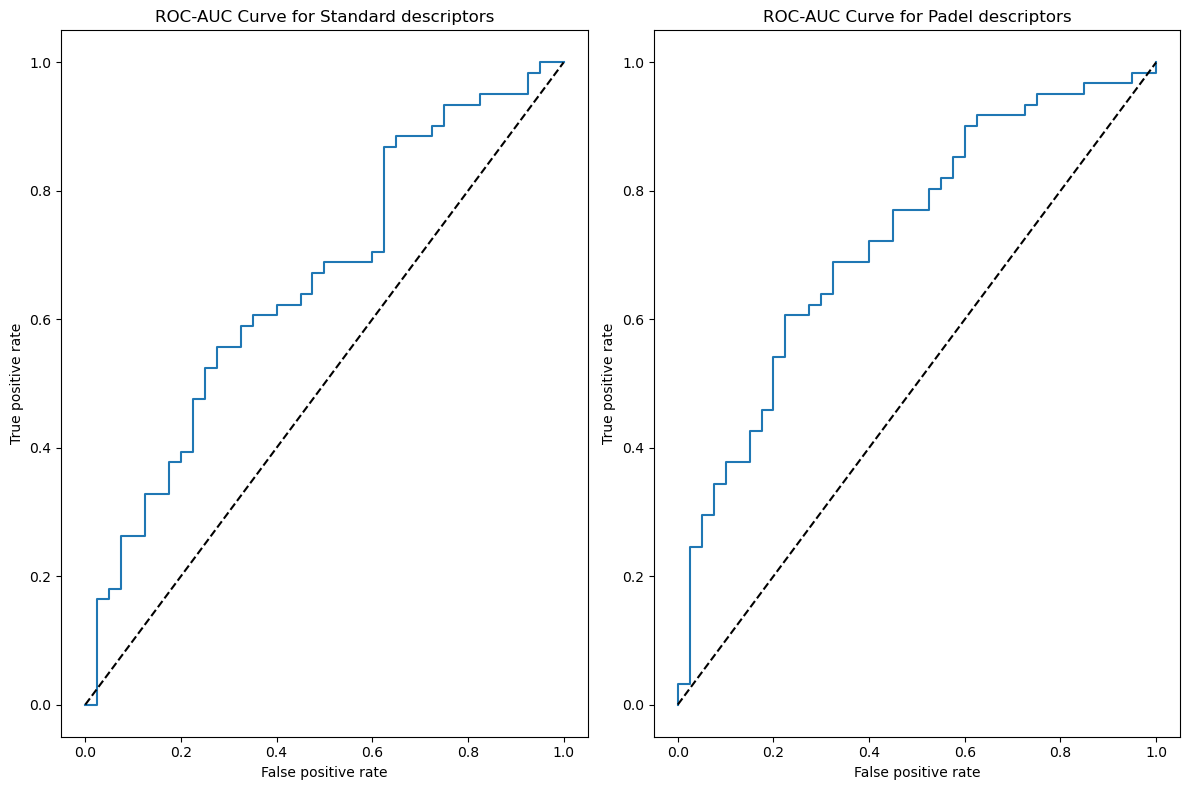

In [52]:
calculate_to_score(LogisticRegression(random_state = 0, max_iter = 1000), estimator_name='Logistic Regression', 
                   param_grid = {'logisticregression__C':hp.loguniform(label = 'C', low = -4*np.log(10), high  = 2*np.log(10)), 'logisticregression__penalty':hp.choice('penalty', ['l2', 'l1'])},
                  groups=groups, descriptors_dict = descriptors_dict_pca, type = 'PCA', target = target )

**Random Forest**

In [57]:
space={'randomforestclassifier__max_depth':hp.randint('max_depth',1,50),  'randomforestclassifier__max_features':hp.choice('max_features', [None, 'sqrt', 'log2']),
       'randomforestclassifier__min_samples_split':hp.randint('min_samples_split', 2, 8),
       'randomforestclassifier__min_samples_leaf': hp.randint('min_samples_leaf', 1, 10)}

100%|██████████| 50/50 [01:36<00:00,  1.93s/trial, best loss: -0.7102598495143632]


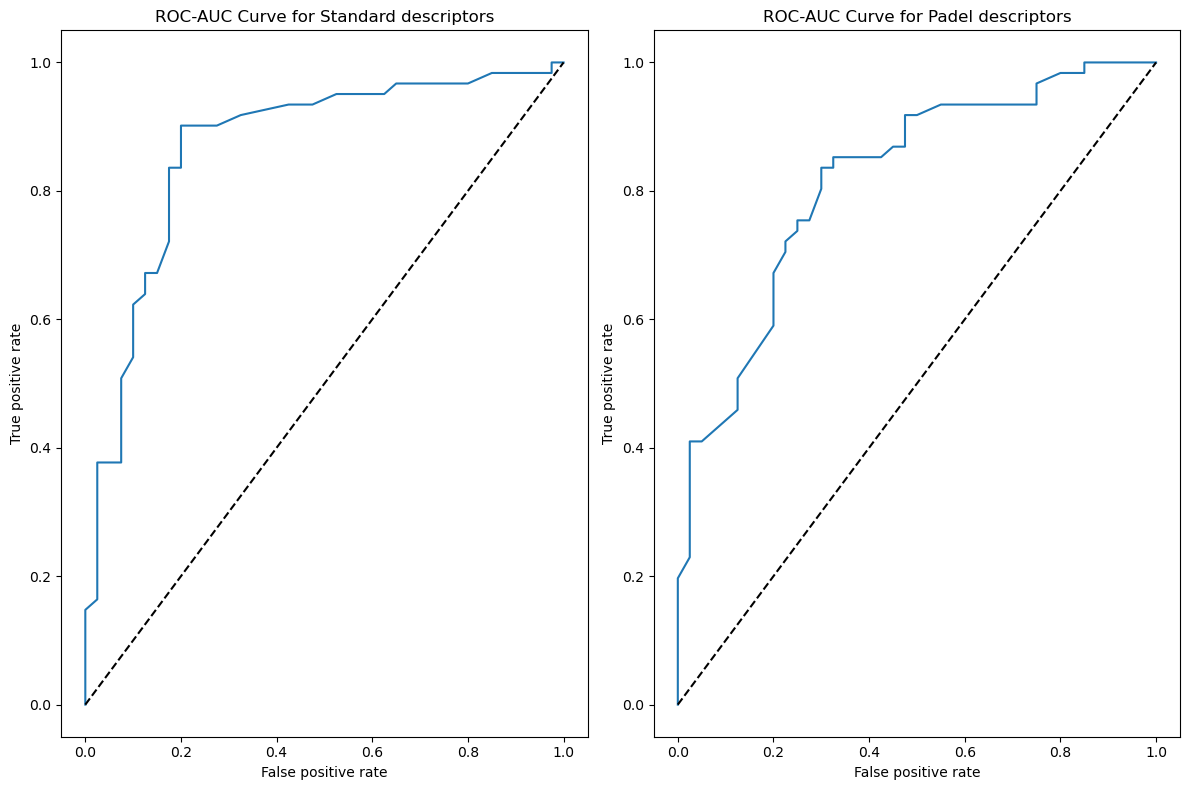

In [59]:
calculate_to_score(RandomForestClassifier(random_state = 0, n_jobs=-1), estimator_name = 'Random Forest', param_grid=space,
                   descriptors_dict=descriptors_dict, groups=groups,
                   target=target,
                   type = 'Full')

100%|██████████| 50/50 [01:59<00:00,  2.40s/trial, best loss: -0.5892536312454776]


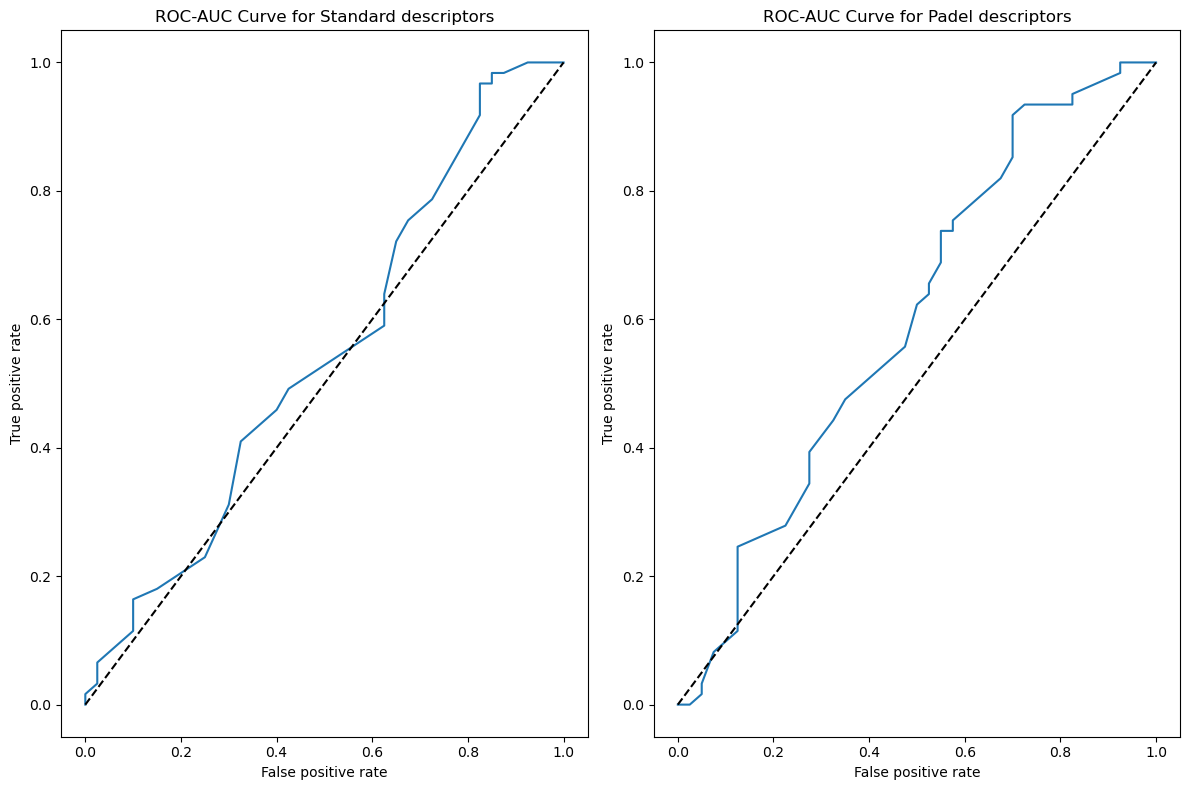

In [66]:
calculate_to_score(RandomForestClassifier(random_state = 0, n_jobs=-1), estimator_name = 'Random Forest', param_grid=space,
                   descriptors_dict=descriptors_dict_pca, groups=groups,
                   target=target,
                   type = 'PCA')

**XGBOOST**

In [72]:
space = {'xgbclassifier__n_estimators':hp.randint('n_estimators', 1, 30),
         'xgbclassifier__learning_rate': hp.loguniform('learning_rate', low = -4*np.log(10), high  = 2*np.log(10)),
         'xgbclassifier__reg_alpha':hp.loguniform(label = 'reg_alpha', low = -4*np.log(10), high  = 2*np.log(10)),
         'xgbclassifier__max_depth':hp.randint('max_depth', 1, 100)}

100%|██████████| 50/50 [03:58<00:00,  4.76s/trial, best loss: -0.751885188518852]


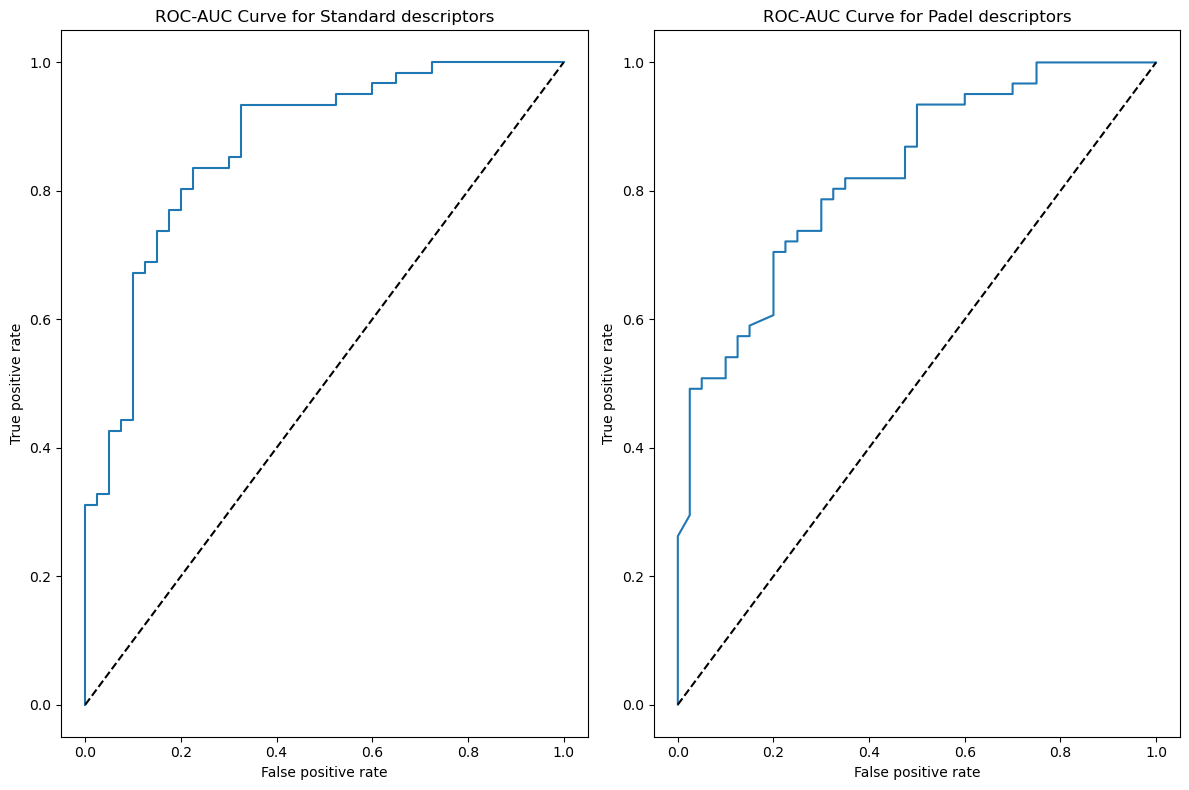

In [74]:
calculate_to_score(XGBClassifier(n_jobs = -1), estimator_name='Gradient boosting', param_grid = space,
                   descriptors_dict=descriptors_dict,
                   target=target,
                   type = 'Full')

100%|██████████| 50/50 [11:56<00:00, 14.33s/trial, best loss: -0.5792714565574204]


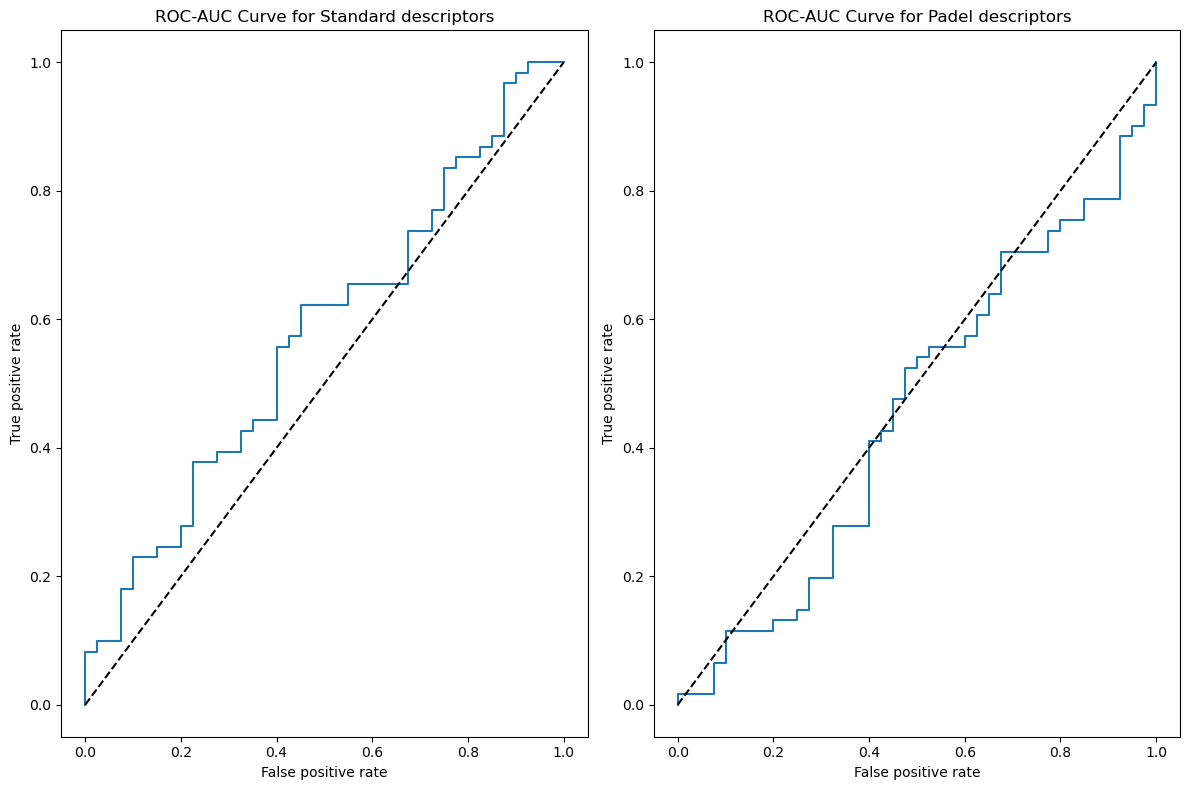

In [80]:
calculate_to_score(XGBClassifier(n_jobs = -1), estimator_name='Gradient boosting', param_grid = space,
                   descriptors_dict=descriptors_dict_pca,
                   target=target,
                   type = 'PCA')

**SVC**

In [86]:
space = {'svc__C':hp.loguniform('C', -3*np.log(10), 2*np.log(10)),
         'svc__kernel':hp.choice('kernel', ['rbf','poly','linear', 'sigmoid']),
         'svc__degree':hp.choice('degree', [2,3, 4]),
         'svc__gamma':hp.choice('gamma', ['scale', 'auto']),
         'svc__coef0':hp.loguniform('coef0', -3*np.log(10), 0*np.log(10))}

100%|██████████| 50/50 [02:17<00:00,  2.76s/trial, best loss: -0.6428242824282429]


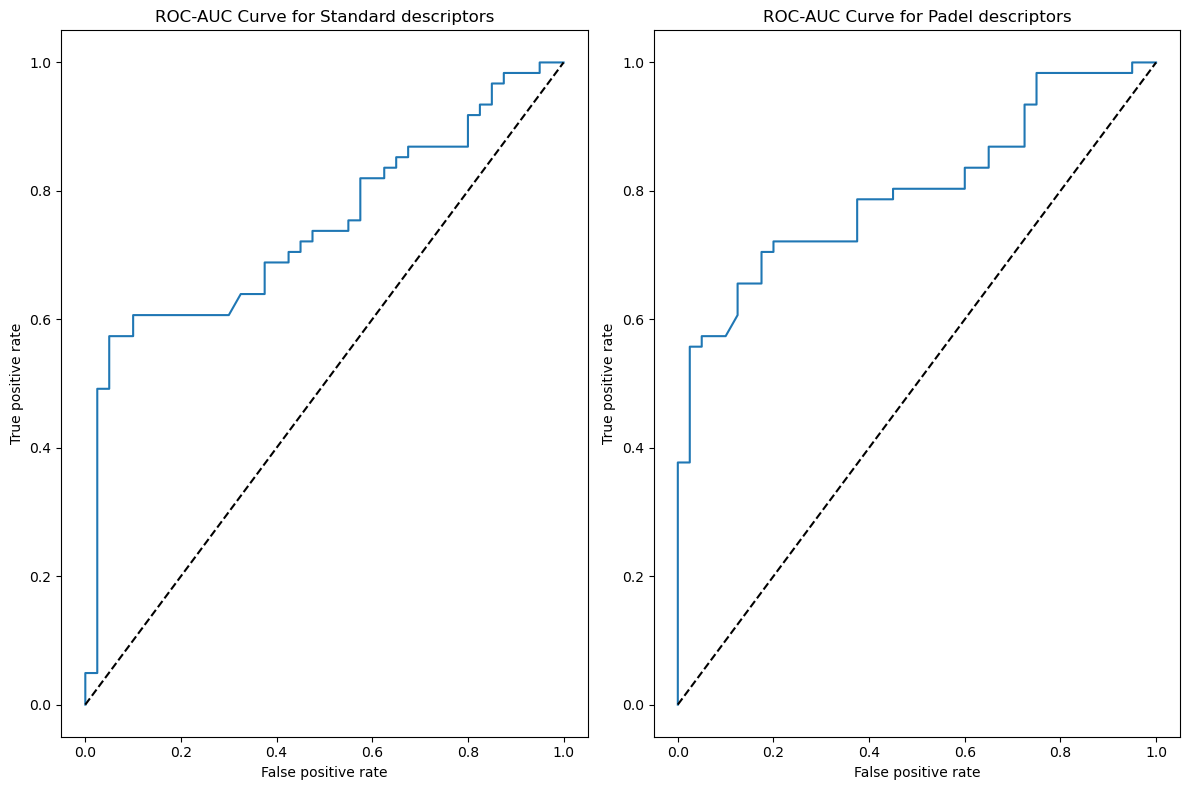

In [88]:
calculate_to_score(SVC(probability=True), estimator_name = 'SVC', param_grid = space, 
                   descriptors_dict=descriptors_dict, target = target, groups=groups, type = 'Full')

100%|██████████| 50/50 [01:19<00:00,  1.60s/trial, best loss: -0.5651953430637182]


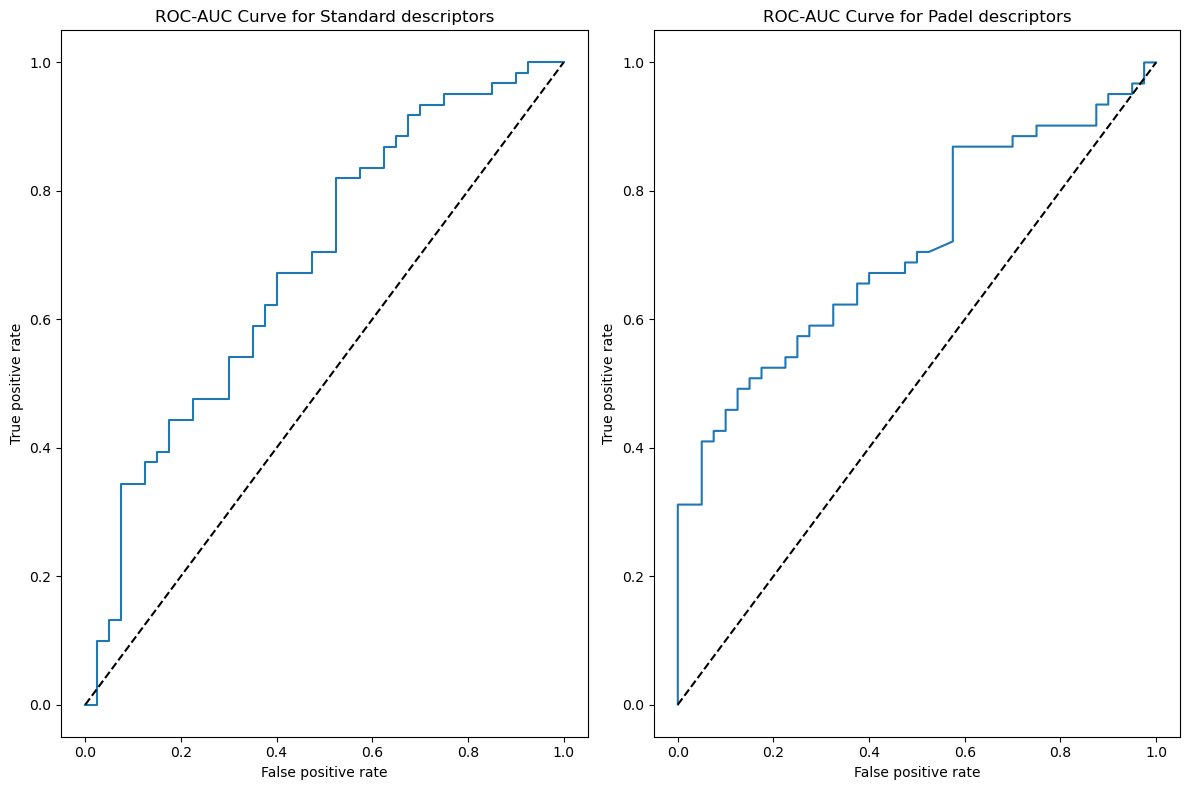

In [90]:
calculate_to_score(SVC(probability=True), estimator_name = 'SVC', param_grid = space, 
                   descriptors_dict=descriptors_dict_pca, target = target, groups=groups, type = 'PCA')

**KNearestNeighbors**

In [94]:
space = {'kneighborsclassifier__n_neighbors':hp.randint('n_neighbors',1, 10),
         'kneighborsclassifier__weights':hp.choice('weights', ['uniform', 'distance']),
         'kneighborsclassifier__metric':hp.choice('metric', ['minkowski', 'chebyshev', 'cosine', 'euclidean'])}


100%|██████████| 50/50 [00:20<00:00,  2.48trial/s, best loss: -0.6943141372960826]


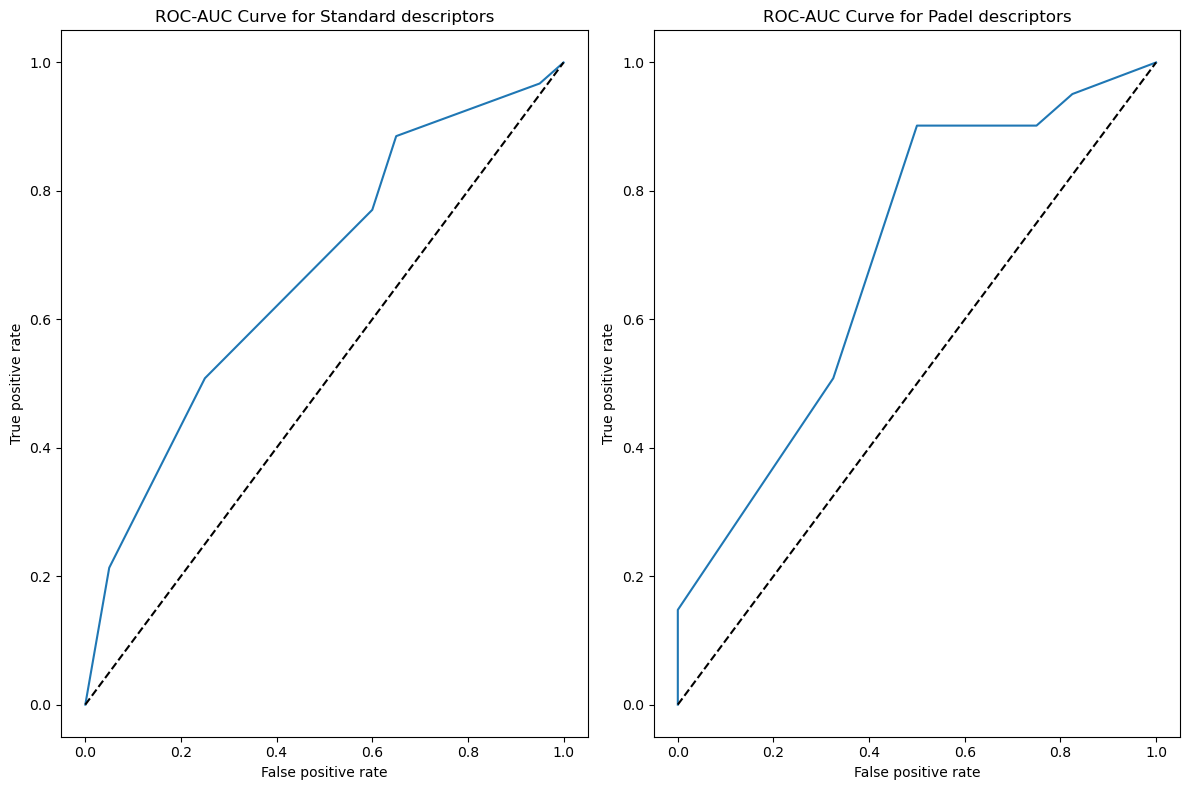

In [101]:
calculate_to_score(KNeighborsClassifier(), estimator_name='KMeans', param_grid=space, 
                   descriptors_dict=descriptors_dict, target=target, groups = groups, type = 'Full')

100%|██████████| 50/50 [00:15<00:00,  3.29trial/s, best loss: -0.504020402040204]


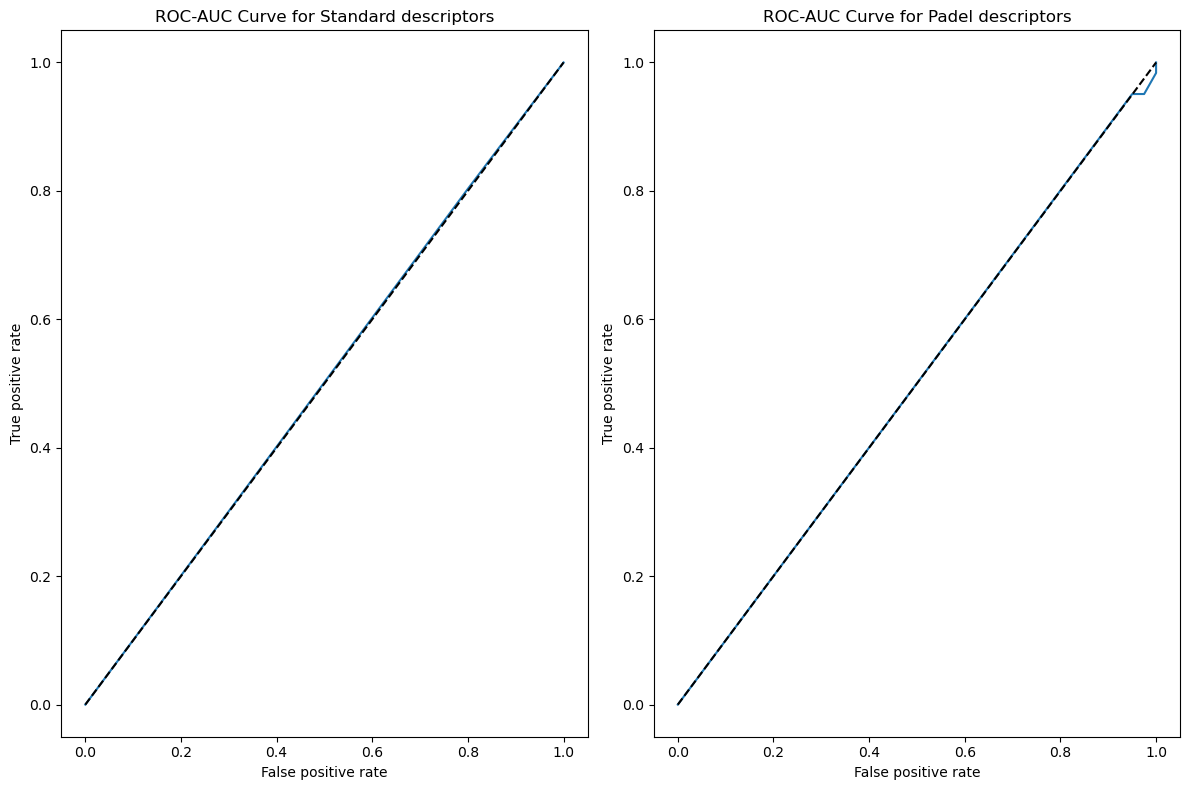

In [104]:
calculate_to_score(KNeighborsClassifier(), estimator_name='KMeans', param_grid=space, 
                   descriptors_dict=descriptors_dict_pca, target=target, groups = groups, type = 'PCA')

In [112]:
with open('score_groups_hyper_opt.pickle', 'wb') as output:
    pickle.dump(scores, output)